Importing Libraries

In [2]:
import pandas as pd
import numpy as np
from numerize import numerize
import plotly.express as px
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import prophet
from prophet.plot import plot_plotly,plot_components_plotly
import scipy
import math
import plotly.figure_factory as ff

import scipy.stats as stats
from fpdf import FPDF

Importing csv data, displaying headings and standardizing numbers

In [3]:
data=pd.read_csv('Startups1.csv')
data.head()
data['fundamt'] = '$' + (data['Funding Amount in $'].astype(float)/1000000).round(2).astype(str) + 'MM'

data.head()



,Unnamed: 0,Company,City,Starting Year,Founders,Industries,Description,No. of Employees,Funding Amount in $,Funding Round,No. of Investors,fundamt
0,0,Urban Company,Gurgaon,2014,"Abhiraj Singh Bhal, Raghav Chandra, Varun Khaitan","Apps, Home Services, Marketplace, Service Indu...",Urban is a marketplace for independent contrac...,1001-5000,445920356,12,16,$445.92MM
1,1,Classplus,Noida,2018,"Bhaswat Agarwal, Bikash Dash, Mukul Rustagi, N...","B2B, E-Learning, EdTech, Education, Mobile App...",Classplus is a mobile-first SaaS platform that...,101-250,89506451,10,20,$89.51MM
2,2,Paytm,Noida,2010,"Akshay Khanna, Vijay Shekhar Sharma","E-Commerce, Finance, Financial Services, Inter...",Paytm is a payment gateway that allows users a...,501-1000,32448851,4,4,$32.45MM
3,3,Apna,Mumbai,2019,Nirmit Parikh,"Employment, Human Resources, Recruiting, Staff...",Apna is a professional networking and job-sear...,101-250,93450000,4,6,$93.45MM
4,4,Razorpay,Bengaluru,2014,"Harshil Mathur, Shashank Kumar","Financial Services, FinTech, Payments, Software","Razorpay is a payment acceptance, processing, ...",1001-5000,366600000,7,29,$366.6MM


Investor Origin Distribution

In [4]:
investororigin=data[['City','No. of Investors']]
investororigin=investororigin.groupby(['City'])['No. of Investors'].sum()
investororigin=pd.DataFrame({'City':investororigin.index,'No. of Investors':investororigin.values})
investororigin=investororigin.sort_values(by=['No. of Investors'],ascending=False).head(10)
fig=px.bar(investororigin,x='City',y='No. of Investors',template='plotly_white',text_auto=True).update_yaxes(showgrid=False).update_yaxes(visible=False).update_layout(font=dict(size=25)).update_traces(marker_color='purple').update_annotations(font=dict(color="red"))
fig.show()
investororigin


# stats.zscore(data['No. of Investors'].values)

,City,No. of Investors
3,Bengaluru,1491
7,Gurgaon,540
14,Mumbai,479
15,New Delhi,191
16,Noida,91
19,Pune,56
4,Chennai,55
13,Kormangala,51
0,Ahmedabad,42
9,Hyderabad,34


Probability Distribution of investors investing in a company from a particular city(Bengaluru Is Highest)

In [5]:
investorssum=investororigin['No. of Investors'].sum()
investororigin['CityWise_pscore']=investororigin['No. of Investors']/investorssum*100
investororigin
fig=px.pie(investororigin,values="CityWise_pscore",names="City",color="CityWise_pscore").update_layout(font=dict(size=20))
fig.show()
investororigin
#probability of an investor investor investing in blr is 47% followed by gurgaon at 17.1% then mumbai at 15.1% and so on

,City,No. of Investors,CityWise_pscore
3,Bengaluru,1491,49.207921
7,Gurgaon,540,17.821782
14,Mumbai,479,15.808581
15,New Delhi,191,6.303630
16,Noida,91,3.003300
19,Pune,56,1.848185
4,Chennai,55,1.815182
13,Kormangala,51,1.683168
0,Ahmedabad,42,1.386139
9,Hyderabad,34,1.122112


Comparison between Average investment from 1985-1999 vs 2000-2020

In [22]:
#filtering years after 2004 since it has a pattern of normal distribution
filtereddf=data.loc[(data['Starting Year']>=2000)]
filtereddf
beforetwothousanddf=data.loc[(data['Starting Year']<2000)]
# mean=data['Funding Amount in $'].mean()#avg investment across the years
# mean
mean1=filtereddf['Funding Amount in $'].mean()
beforetwothousandmean=beforetwothousanddf['Funding Amount in $'].mean()
mean1#avg investment value from 2000-2020
beforetwothousandmean#avg investment value from 1985-1999


comparisondata=[[beforetwothousandmean],[mean1]]

#dataframe to show comparison before 2000 vs after 2000
comparisondf=pd.DataFrame(comparisondata,columns=['Avg Investment Amount'])
comparisondf['Timespan']=['1985-1999','2000-2020']
comparisondf

#plotting the graph
fig=px.bar(comparisondf,x='Timespan',y='Avg Investment Amount',template='plotly_white',text_auto=True,color='Timespan',color_discrete_sequence=['grey','green']).update_yaxes(visible=False).update_layout(font=dict(size=20))
fig.show()
comparisondf

#2000-2020 has seen nearly a 2x increase in investment


,Avg Investment Amount,Timespan
0,1.693587e+08,1985-1999
1,3.199477e+08,2000-2020


Future Total Investment Patterns That Can Be Raised By Startups From (2021-2029)

10:36:02 - cmdstanpy - INFO - Chain [1] start processing
10:36:03 - cmdstanpy - INFO - Chain [1] done processing


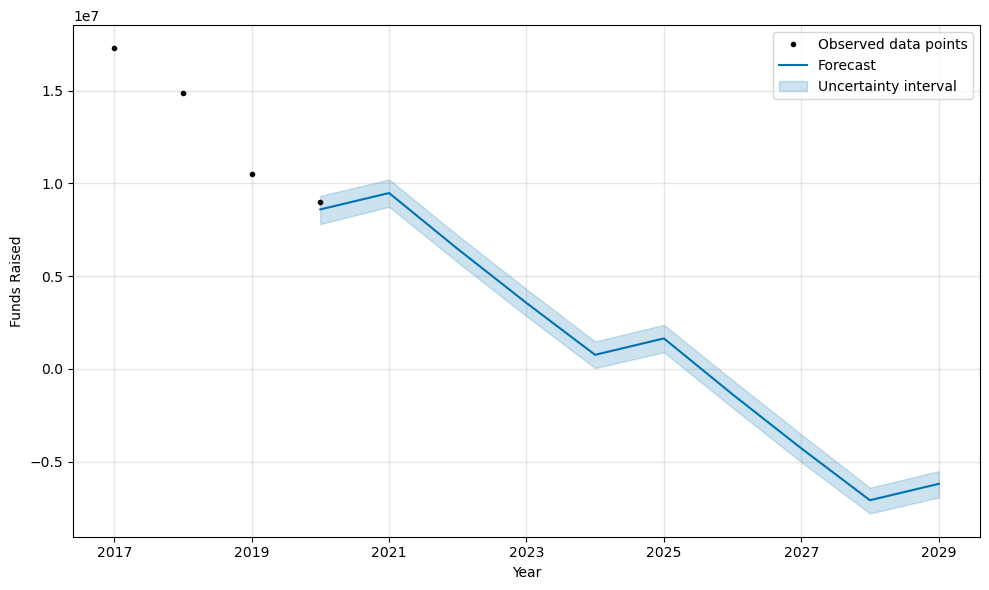

In [7]:
#isolating last 4 years data to make a prediction
fiveyeardf=data.loc[(data['Starting Year']>2016)]
fiveyeardf

#calculating yearly average every 5 years
yearlyavg=fiveyeardf[['Starting Year','Funding Amount in $']]

#calculating total funds raised
yearlyavg=yearlyavg.groupby(['Starting Year'])['Funding Amount in $'].median()
yearlyavg=pd.DataFrame({'ds':yearlyavg.index,'y':yearlyavg.values})
yearlyavg['ds'] = pd.to_datetime(yearlyavg['ds'], format='%Y')

#defining prophet model and fitting df in it
model=prophet.Prophet()
model.fit(yearlyavg)

#defining period whose prediction we want
future=list()
for i in range(0,10):
    date=f'202{i}-01-01'
    future.append([date])

future=pd.DataFrame(future)
future.columns=['ds']
future
future['ds'] = pd.to_datetime(future['ds'])
# #using model to make a forecast
forecast = model.predict(future)
model.plot(forecast)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Funds Raised")
label=["ss","dd"]
plt.show()
plot_plotly(model,forecast)
plot_components_plotly(model,forecast)




z score calculation and interpretation analysis for funding rounds

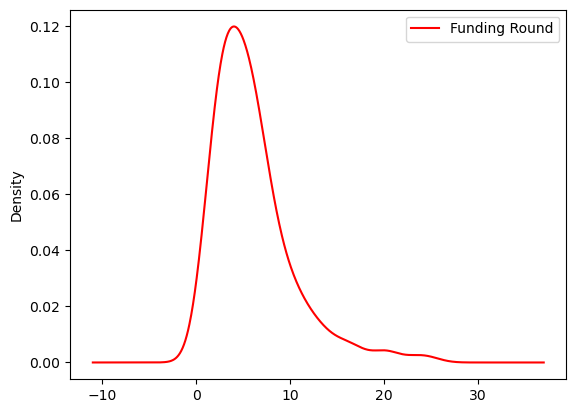

In [64]:
#removing any outliers
data=data.loc[(data['Funding Round']>0)]
#calculating z scores
zscoree=stats.zscore(data['Funding Round'])
zscoree=abs(zscoree)
zscoree
data['zscore_for_fundinground']=zscoree


#getting percentile for z score
def zptile(z_score):
    return .5 * (math.erf(z_score / 2 ** .5) + 1)
data["PTILE_for_fundinground"]=data['zscore_for_fundinground'].apply(zptile)
data[["PTILE_for_fundinground"]]=data[["PTILE_for_fundinground"]].round(2)
data[["PTILE_for_fundinground"]]
data['percentroundfunding'] = data['PTILE_for_fundinground'].astype(float).map("{:.2%}".format)
topfivepercentinvestors=data.loc[(data['percentroundfunding']<'5')] 
greaterthanfiftyfunds=data.loc[(data['percentroundfunding']>='50')]
greaterthanfiftyfunds=greaterthanfiftyfunds.loc[(greaterthanfiftyfunds['percentroundfunding']<'90')]
lessthantenfunds=data.loc[(data['percentroundfunding']<'5')]

data['Funding Round'].plot.density(color="red")

plt.legend()
plt.show()
#Funding Rounds Raised By Less Than 5 percent of the companies
fig=px.bar(topfivepercentinvestors,x='Company',y='Funding Round',template='plotly_white',text_auto=True,color='Funding Round').update_yaxes(visible=False).update_layout(font=dict(size=20))
fig.show()

boxplot=px.box(topfivepercentinvestors,y='Funding Round',title='Boxplot Distribution for funding raised by top 5% of the companies')
boxplot.show()

#Funding Rounds raised by most companies(50-90%)
boxplot=px.box(greaterthanfiftyfunds,y='Funding Round',title='Boxplot Distribution for funding raised by 50-90% of the companies')
boxplot.show()





Starting Year Analysis

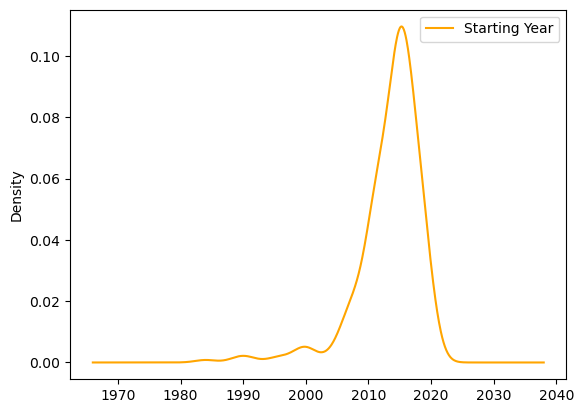

In [73]:
data['Starting Year'].plot.density(color="orange")

plt.legend()
plt.show()

#calculating z score for starting year
zscore_startingyr=stats.zscore(data['Starting Year'])
zscore_startingyr=abs(zscore_startingyr)
zscore_startingyr
data['zscore_for_startingyr']=zscore_startingyr
data

#calculating percentile
def zptile(z_score):
    return .5 * (math.erf(z_score / 2 ** .5) + 1)

data["PTILE_for_startingyr"]=data['zscore_for_startingyr'].apply(zptile)
data[["PTILE_for_startingyr"]]=data[["PTILE_for_startingyr"]].round(2)
data[["PTILE_for_startingyr"]]
data['percentstartingyr'] = data['PTILE_for_startingyr'].astype(float).map("{:.2%}".format)


#Less than 5 percent of companies started their ventures from 1984-2000
yeargt=data.loc[(data['percentstartingyr']<'5')]
yearcount=yeargt.groupby('Starting Year')['Starting Year'].count()
yearcount=pd.DataFrame({'Year':yearcount.index,'Count':yearcount.values})

boxplot=px.pie(yearcount,names='Year',values='Count',color='Count',title='Company Distribution from 1984-2000').update_layout(font=dict(size=20))
boxplot.show()

#70-90 percent of the companies started their ventures from 2007 to 2019(i.e. majority of companies)
yeargtthan=data.loc[(data['percentstartingyr']>='70')]
yeargtthan=yeargtthan.loc[(yeargtthan['percentstartingyr']<='90')]
yeargtcount=yeargtthan.groupby('Starting Year')['Starting Year'].count()
yearcountcnt=pd.DataFrame({'Year':yeargtcount.index,'Count':yeargtcount.values})
yeartreemap=px.treemap(yearcountcnt,values='Count',path=['Year','Count'],color='Count',color_continuous_scale='RdBu').update_layout(font=dict(size=20))
yeartreemap.show()

# boxplot=px.box(data,y='Starting Year')
# boxplot.show()


Generating The PDF Report

In [76]:
#cell height
ch=8

pdf = FPDF()
pdf.add_page()
pdf.set_font('Arial', 'B', 24)
pdf.cell(w=0, h=20, txt="Startup Analysis Report", ln=1)
pdf.set_font('Arial', '', 12)
pdf.cell(w=30, h=ch, txt="Date: ", ln=0)
pdf.cell(w=30, h=ch, txt="03/04/2023", ln=1)
pdf.cell(w=30, h=ch, txt="Author: ", ln=0)
pdf.cell(w=30, h=ch, txt="Shuprotik Roy", ln=1)
pdf.set_font('Arial', 'B', 14)
pdf.cell(w=30, h=ch, txt="Top 10 places chosen by startup companies", ln=1)
pdf.image('./pieplot.png', 
          x = 0, y = None, w = 200, h = 0, type = 'PNG')

pdf.set_font('Arial', 'B', 12)
pdf.set_text_color(r= 62.7, g= 12.5, b = 94.1)
pdf.cell(w=30, h=10, txt="1.Bengaluru is the home of the highest no of successful startups", ln=1)
pdf.cell(w=0, h=5, txt="2. 3/10 successful cities are from the northern side of India", ln=1)
pdf.set_font('Arial', 'B', 14)
pdf.set_text_color(r= 0, g= 0, b = 0)
pdf.cell(w=0, h=15, txt="Probability chances of a company belonging from a particular city", ln=1)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(w=0, h=5, txt="To find this, we calculated individual probability scores for a company by grouping number of companies per city and then using the formula i.e. no of companies for a city/total companies in India")
pdf.image('./propplot.png', 
          x = 0, y = None, w = 200, h = 0, type = 'PNG')
pdf.set_font('Arial', 'B', 11)
pdf.set_text_color(r= 100, g= 0, b = 0)
pdf.cell(w=30, h=10, txt="1.Bengaluru has the highest chance of hosting successful startups", ln=1)
pdf.set_text_color(r= 100, g= 64.7, b = 0)
pdf.cell(w=30, h=10, txt="2.Hyderabad has the least chance of hosting successful startups", ln=1)
pdf.set_text_color(r= 62.7, g= 12.5, b = 94.1)
pdf.cell(w=30, h=10, txt="3.New Delhi has a median chance of hosting successful startups", ln=1)

#page 2
pdf.add_page()
pdf.set_font('Arial', 'B', 14)
pdf.set_text_color(r= 0, g= 0, b = 0)
pdf.cell(w=0, h=20, txt="Avg Investment Amount Comprison(Before 2000 vs After 2000)", ln=1)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(w=0, h=5, txt="Here we grouped the two time periods and calculated the mean value of the total investment values, as per the data post 2000 saw a massive rise of new startups leading to an influx of investments")
pdf.image('./timeplot.png', 
          x = 0, y = None, w = 200, h = 0, type = 'PNG')
pdf.set_font('Arial', 'B', 12)
pdf.set_text_color(r= 0, g= 100, b = 0)
pdf.cell(w=0, h=20, txt="Post 2000's saw a massive growth of 1.8x in the amount of funds raised by successful startups", ln=1)
pdf.set_font('Arial', 'B', 14)
pdf.set_text_color(r= 0, g= 0, b = 100)
pdf.cell(w=0, h=20, txt="Investment Regression Analysis", ln=1)
pdf.set_font('Arial', '', 12)
pdf.set_text_color(r= 0, g= 0, b = 0)
pdf.multi_cell(w=0, h=5, txt="Here we calculated median value of investments grouped by years(2016-2020) and then fit this data into a regression model facilitated by fbprophet which helped us to get a rough estimate of the future trends that can occur.")
pdf.image('./trend.png', 
          x = 0, y = None, w = 200, h = 0, type = 'PNG')
pdf.image('./output.png', 
          x = 0, y = None, w = 200, h = 0, type = 'PNG')
pdf.set_font('Arial', 'B', 12)
pdf.set_text_color(r= 0, g= 0, b = 100)
pdf.cell(w=30, h=15, txt="1.2021 will see a slight rise in funds raised, then will go on a declining spree uptill 2024", ln=1)
pdf.cell(w=30, h=10, txt="2.Overall, the median amount of investments will decrease in startups with time", ln=1)
pdf.cell(w=30, h=10, txt="3.Mid of each month seems like a great time to raise funds", ln=1)
pdf.set_font('Arial', 'B', 14)
pdf.set_text_color(r= 0, g= 0, b = 0)
pdf.cell(w=0, h=20, txt="Funding Round Z Score Analysis", ln=1)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(w=0, h=5, txt="In here, we isolated the funding rounds held by the companies and since the data was normally distributed, used z score analysis to get a better insight of the data distribution in hand. Percentile on basis of the z scores were calculated and following conclusions were drawn:-")
pdf.set_font('Arial', 'B', 12)
pdf.set_text_color(r= 100, g= 0, b = 0)
pdf.cell(w=30, h=10, txt="1.50-90% Companies have conducted their 1st to 17th funding round", ln=1)
pdf.cell(w=30, h=10, txt="2.<5% Companies have conducted their 17th to 25th funding round", ln=1)
pdf.cell(w=30, h=10, txt="3.20th round was the median funding round conducted by top 5% of the companies", ln=1)
pdf.cell(w=30, h=10, txt="4.5th round was the median funding round conducted by 50-90% of the companies", ln=1)
pdf.set_text_color(r= 0, g= 0, b = 0)
pdf.cell(w=0, h=20, txt="Funding Round for top 5% companies bar visualization", ln=1)
pdf.image('./fundingzchart.png', 
          x = 0, y = None, w = 200, h = 0, type = 'PNG')
pdf.set_font('Arial', 'B', 14)
pdf.cell(w=0, h=20, txt="Starting Year Z Score Analysis", ln=1)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(w=0, h=5, txt="Z scores of normally distributed data of starting years were calculated and accordingly, percentiles of the same z scores were analysed and interpreted to get a better understanding of the data in focus and understand it's distribution")
pdf.set_font('Arial', 'B', 12)
pdf.cell(w=30, h=10, txt="1.>5% Companies started their companies from 1984-2000", ln=1)
pdf.image('./distributionplot.png', 
          x = 0, y = None, w = 200, h = 0, type = 'PNG')
pdf.cell(w=30, h=10, txt="2.70-90% of the companies started their ventures from 2007 to 2019(i.e. majority of companies)", ln=1) 
pdf.set_font('Arial', '', 12)
pdf.multi_cell(w=0, h=5, txt="In here, we created a heatmap visualization of the year origin distribution for 70-90% of the companies which showed that in 2017 most of the companies were opened for this given sample population. Below visualization shows the heatmap distribution for the given data along with it's origin year")         
pdf.image('./newplot.png', 
          x = 0, y = None, w = 200, h = 0, type = 'PNG')


	
pdf.output(f'./startupanalysisreport.pdf', 'F')


''